In [1]:
# https://qiita.com/issakuss/items/d30303e200756980ae45#%E7%92%B0%E5%A2%83

In [2]:
# versionの確認。
import sys
print(sys.version)

# のちにエラーが出るので、SSL認証のデバグ用に。
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

3.9.1 (v3.9.1:1e5d33e9b9, Dec  7 2020, 12:10:52) 
[Clang 6.0 (clang-600.0.57)]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

In [4]:
url = "https://www.basketball-reference.com/leagues/NBA_2020_per_game.html"

In [5]:
data = pd.read_html(url)[0]

In [6]:
# DataFrame の整形。

drop_li = []

for i in range(len(data)):
    if data.iloc[i, 0] == 'Rk':
        drop_li.append(i)
    else:continue
        
data = data.drop(data.index[drop_li])

Rk -- Rank
Pos -- Position
Age -- Player's age on February 1 of the season
Tm -- Team
G -- Games
GS -- Games Started
MP -- Minutes Played Per Game
FG -- Field Goals Per Game
FGA -- Field Goal Attempts Per Game
FG% -- Field Goal Percentage
3P -- 3-Point Field Goals Per Game
3PA -- 3-Point Field Goal Attempts Per Game
3P% -- 3-Point Field Goal Percentage
2P -- 2-Point Field Goals Per Game
2PA -- 2-Point Field Goal Attempts Per Game
2P% -- 2-Point Field Goal Percentage
eFG% -- Effective Field Goal Percentage
This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.
FT -- Free Throws Per Game
FTA -- Free Throw Attempts Per Game
FT% -- Free Throw Percentage
ORB -- Offensive Rebounds Per Game
DRB -- Defensive Rebounds Per Game
TRB -- Total Rebounds Per Game
AST -- Assists Per Game
STL -- Steals Per Game
BLK -- Blocks Per Game
TOV -- Turnovers Per Game
PF -- Personal Fouls Per Game
PTS -- Points Per Game

In [7]:
# データの整形 part.2 
# 変数は ['AST', 'STL', 'BLK', 'PTS'] とする。

stats_li = ['TRB','AST', 'STL', 'BLK', 'PTS']
data.iloc[:, 5:] = data.iloc[:, 5:].astype(float)

#一試合当たり30分以上出場&試合数が20を超えている選手のみを使用。
data = data[data['MP'] >= 30][data['G'] >= 20]

data = pd.concat([data['Player'], data[stats_li]], axis = 1)
data

,Player,TRB,AST,STL,BLK,PTS
1,Bam Adebayo,10.2,5.1,1.1,1.3,15.9
2,LaMarcus Aldridge,7.4,2.4,0.7,1.6,18.9
12,Giannis Antetokounmpo,13.6,5.6,1.0,1.0,29.5
15,Carmelo Anthony,6.3,1.5,0.8,0.5,15.4
20,Trevor Ariza,4.8,2.0,1.6,0.4,11.0
...,...,...,...,...,...,...
648,Russell Westbrook,7.9,7.0,1.6,0.4,27.2
651,Hassan Whiteside,13.5,1.2,0.4,2.9,15.5
652,Andrew Wiggins,5.1,3.7,0.8,1.0,21.8
653,Andrew Wiggins,5.2,3.7,0.7,0.9,22.4


In [8]:
# DataFrameの数値がstr型であったため、float型に変換する。

data[stats_li] = data[stats_li].astype(float)

In [9]:
# Player が別のチームにトレードされた場合、名前がデータに複数含まれていることがある。そのため名前でgroup化を行い、stats は平均値を使う。

use_data = data.groupby('Player').mean()

In [10]:
# 参考 : https://ensekitt.hatenablog.com/entry/2018/08/08/200000
# 主成分分析は変数ごとに標準化する必要がある。

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(use_data)
scaler.transform(use_data)
std_data = pd.DataFrame(scaler.transform(use_data), columns=use_data.columns)

In [11]:
# 平均が0, 分散が1になっているか確認。

std_data.describe()

,TRB,AST,STL,BLK,PTS
count,8.700000e+01,8.700000e+01,8.700000e+01,8.700000e+01,8.700000e+01
mean,8.294770e-16,7.437378e-17,6.482682e-16,-1.378208e-16,-3.317908e-17
std,1.005797e+00,1.005797e+00,1.005797e+00,1.005797e+00,1.005797e+00
min,-1.531806e+00,-1.332891e+00,-1.722660e+00,-9.955501e-01,-2.200728e+00
25%,-7.469785e-01,-9.345500e-01,-6.653662e-01,-6.246171e-01,-8.023122e-01
50%,-3.375033e-01,-1.821279e-01,-1.367191e-01,-2.536841e-01,-6.630417e-02
75%,3.961398e-01,8.690501e-01,5.240898e-01,2.099822e-01,5.501026e-01
max,3.108913e+00,2.650520e+00,2.770840e+00,4.197512e+00,2.840928e+00


In [12]:
# http://i.cla.kobe-u.ac.jp/murao/class/2015-SeminarB3/05_Python_de_PCA.pdf

In [13]:
n_components = 2

pca = PCA(n_components = n_components)
pca.fit(std_data)

PCA(n_components=2)

In [14]:
#重みづけ係数や寄与率をDataFrameで出力。

pca_df1 = pd.DataFrame(pca.explained_variance_ratio_).T
pca_df2 = pd.DataFrame(pca.components_).T
pca_df = pd.concat([pca_df1, pca_df2])

pca_df.columns = ['第一主成分', '第二主成分']

stats_li.insert(0, '寄与率')
pca_df.index = stats_li

pca_df

,第一主成分,第二主成分
寄与率,0.396531,0.306855
TRB,0.477298,0.499873
AST,-0.548790,0.345333
STL,-0.288905,0.402465
BLK,0.545641,0.420158
PTS,-0.299709,0.540705


In [15]:
#主成分空間に写像。x軸とy軸が出力される。

x = pca.transform(std_data)

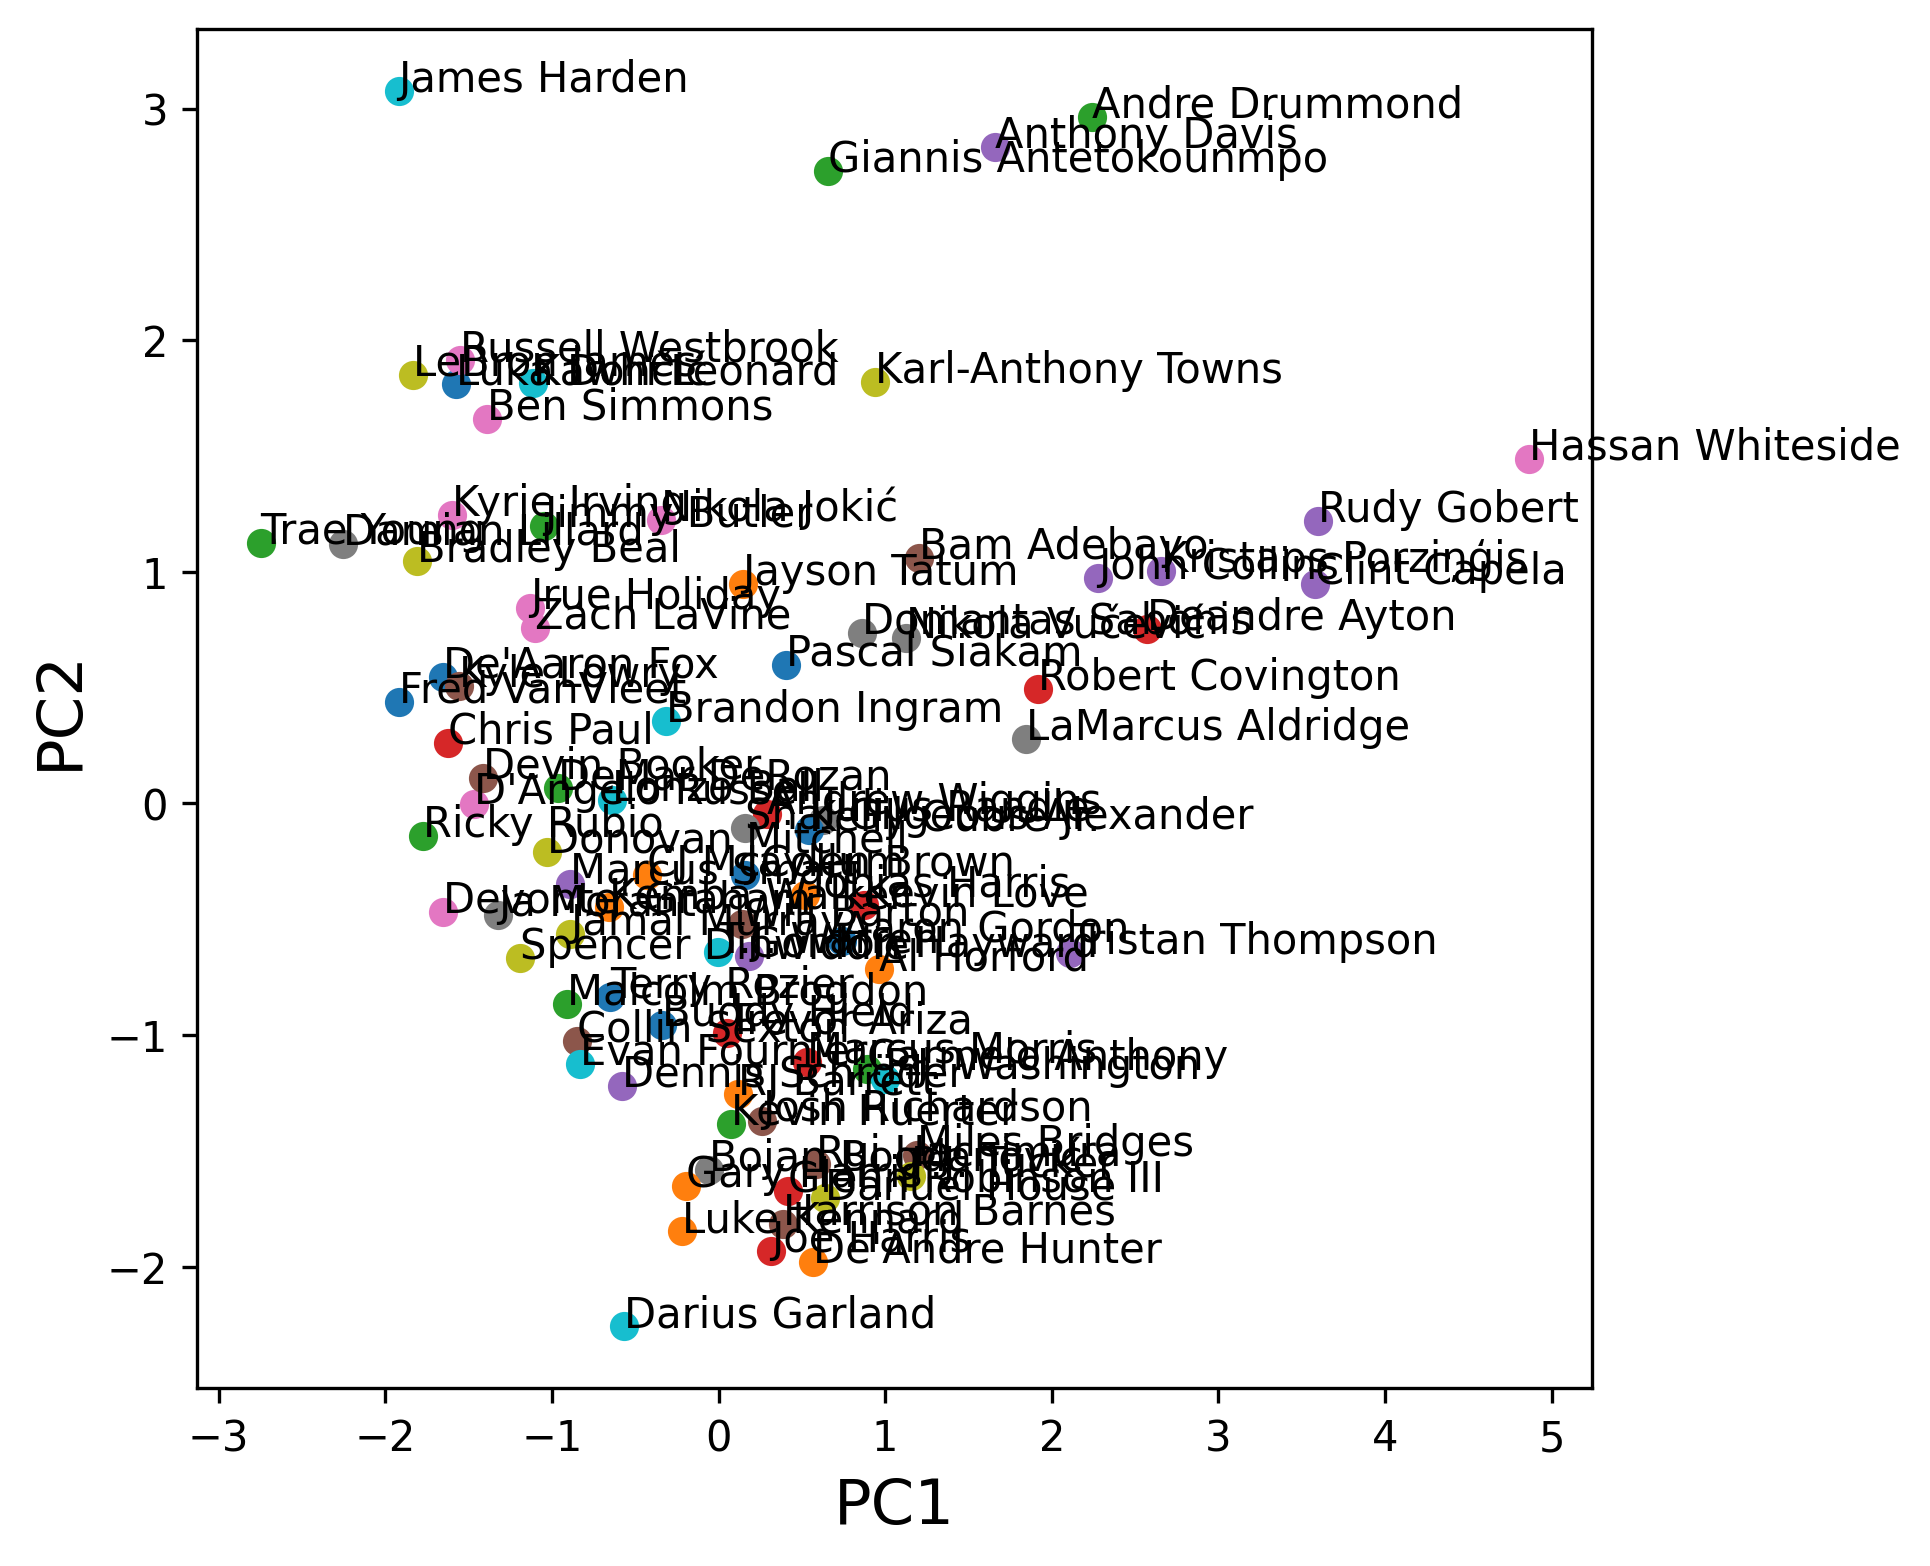

In [16]:
# plt.scatter !!

fig = plt.figure(figsize = (6, 6), dpi = 300)

for i in range(len(std_data)):
    plt.scatter(x[i, 0], x[i, 1], label = use_data.index[i])
    plt.annotate(xy = (x[i, 0], x[i, 1]), s = use_data.index[i])

plt.xlabel('PC1', fontsize = 15)
plt.ylabel('PC2', fontsize = 15)

plt.savefig('image.png', bbox_inches='tight')
plt.show()

In [17]:
# 第二主成分に総合力があらわれた模様。第一主成分はセンター特性が大きく反映されている？